This notebook contains a Black Friday Analysis for Shoprite predicting their Black Friday Campaign and giving insights on the major things to focus on. It contains an insight into the different grades of customers, grades of products and best selling times. It also assists with an insight to how to give dscount for each product to maximize sales.


In [1]:
import os
print(f"Using:", {os.cpu_count})
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["LOKY_MAX_CPU_COUNT"] = "2"

Using: {<built-in function cpu_count>}


In [2]:
import csv
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


filepath = "Project\\Odumosu Hannah.csv"
print(os.path.abspath(filepath))
print(filepath)
df = pd.read_csv("c:\\Users\\MY PC\\New folder\\Project\\Odumosu Hannah.csv")
pprint(df.columns.tolist())    

def str_to_float(value):
    return float(str(value))

class BlackFridaySalesanalyzer:
    def __init__(self, path):
        try:
            self.df = pd.read_csv(path)

            self.rename_columns()
            
            # self.pre_process_data()

        except FileNotFoundError:
            print(f"File not found at: {path}.")

            self.df = None

            return

    def rename_columns(self):
        self.df.rename(columns = {
            "Date": "date",
            "Time": "time",
            "CustomerID": "customer",
            "Age": "age",
            "Gender":"gender",
            "Location": "location",
            "OnlineOrderFlag": "online",
            "ProductID": "productid",
            "ProductName": "productname",
            "Category": "category",
            "Quantity": "quantity",
            "UnitPrice": "unitprice",
            "TotalPrice": "totalprice",
            "PaymentType": "paymentmode",
            "PromotionApplied": "promotion",
            "DiscountAmount": "discount",
            "ShippingMethod": "shippingmethod",
            "DeliveryTime": "deliverytime",
            "CustomerSatisfaction": "satisfaction",}, inplace = True)        

    def pre_process_data(self): 
        self.rename_columns()
        self.df["date"] = pd.to_datetime(self.df["date"].astype(str).str.strip(), format="%m/%d/%Y", errors="coerce")
        self.df["year"] = self.df["date"].dt.year
        self.df["month"] =pd.to_datetime(self.df["date"]).dt.month
        self.df["day"] = self.df["date"].dt.day
        self.df["weekday"] = self.df["date"].dt.dayofweek
        self.df["weekend"] = self.df["weekday"].isin([5,6]).astype(int)
        self.df["time"] = pd.to_datetime(self.df["time"].astype(str).str.strip(), format="%H:%M:%S", errors="coerce")
        
        def categorizetime(t):
            if t.hour < 12:
                return "Morning"
            elif t.hour < 17:
                return "Afternoon"
            elif t.hour < 21:
                return "Evening"
            else:
                return "Night"
            
        def agerange(age):
            if age < 30:
                return "Young Adult"
            elif age < 50:
                return "Adult"
            else:
                return "Aged"

        self.df["age"] = pd.to_numeric(self.df["age"], errors = "coerce")
        self.df["agerange"] = self.df["age"].apply(agerange)
        self.df["daytime"] = self.df["time"].apply(categorizetime)

        cols = ["date","time", "customer", "age", "gender", "location", "online", "productid", "productname", "category", "quantity", "unitprice", "totalprice", "paymentmode", "promotion", "discount", "shippingmethod", "deliverytime", "satisfaction"]
        # print("=*10", "Number of empty cells per column", "=*10")
        print(self.df[cols].isnull().sum().sort_values(ascending = False))
        self.df.dropna(subset = cols, inplace = True)
        self.df[self.df[cols].isna().all(axis=1)]
        print(f"File has {len(self.df)} rows and {len(self.df.columns)} columns\n")
        
        self.df["unitprice"] = self.df["unitprice"].apply(lambda x: float(str(x)))
        self.df["totalprice"] =self.df["totalprice"].apply(str_to_float)

    def data_overview(self):  

        print("="*30, "DEV DESIGN BOOTCAMP PROJECT", "="*30)
        print("\n", "="*30, "BLACK FRIDAY SALES ANALYSIS", "="*30)
        
        (row, columns) = self.df.shape

        
        min_time = self.df['time'].min()
        max_time = self.df['time'].max()
        min_date = self.df['date'].min()
        max_date = self.df['date'].max()

        print(f"Total records: {row}")
        print(f"Time range: {min_time.strftime('%H:%M:%S')} to {max_time.strftime('%H:%M:%S')}")
        print(f"Date range: {min_date.strftime('%m:%d:%Y')} to {max_date.strftime('%m:%d:%Y')}")
        print(f"Unique products: {self.df["productname"].nunique()}")
        print(f"Unique categories: {self.df["category"].nunique()}")
        print(f"Unique locations: {self.df["location"].nunique()}")
        print("\n")        

        print("="*30, "$FINANCIAL SUMMARY", "="*30)
        Totalrevenue = (f"${self.df["totalprice"].sum():.2f}")
        Aveordervalue = (f"${self.df["totalprice"].mean():.2f}")

        print(f"Total Revenue = ${Totalrevenue}")
        print(f"Average Revenue = ${Aveordervalue}")
        print(" ")

        #DATA QUALITY SCORE
        missing_data = self.df.isnull().sum()
        data_quality_score =(f" {(len(self.df) - (len(self.df.columns)- missing_data.sum())) / len(self.df) * 100:.2f}%")
        print(f"DATA HEALTH SCORE: {data_quality_score}")
        print(" ")

        print("="*15, "STATUS DISTRIBUTION", "="*15)
        columns = ["agerange", "daytime", "productname", "location", "customer"]
        Labels = ["Buyer Grades", "Sales period", "Selling Products", "Buying Cities", "Loyal Customers"]
        for col, label in zip(columns, Labels):
           statusdistribution = {
               "top_performers": self.df[col].value_counts().head(3),
                "bottom_performers": self.df[col].value_counts().tail(3)
                }
           
           print(f"\nTop Three Highest {label} are:")
           for value, counts in statusdistribution["top_performers"].items():
               percentage = (counts / len(self.df)) * 100
               print(f"{value}: {counts} ({percentage:.2f}%)")

           print(f"\nBottom Three Lowest {label} are:")
           for value, counts in statusdistribution["bottom_performers"].items():
               percentage = (counts / len(self.df)) * 100
               print(f"{value}: {counts} ({percentage:.2f}%)")
        print("\n")
    
        totalrevenue = self.df["totalprice"].sum()
        customerdistribution = self.df.groupby("agerange")["totalprice"].sum().reset_index(name = "revenue").assign(percentage = lambda df:(df["revenue"] / totalrevenue) * 100).sort_values("revenue", ascending = False).head(5)
        productdistribution = self.df.groupby("productname").agg(
            totalquantity = ("quantity", "sum"),
            revenue = ("totalprice", "sum")
        ).reset_index().assign(percentage = lambda df:(df["revenue"] /totalrevenue) * 100).sort_values("revenue", ascending = False).head(5)
        citydistribution = self.df.groupby("location")["totalprice"].sum().reset_index(name = "revenue").assign(percentage = lambda df:(df["revenue"] /totalrevenue) * 100).sort_values("revenue", ascending = False).head(5)
        # percentage = (distribution["count"] / len(self.df)) * 100

        print("="*15, "CUSTOMER DISTRIBUTION", "="*15)
        for _, row in customerdistribution.iterrows():
            print(f"{row["agerange"]}: ${row["revenue"]:.2f}, ({row["percentage"]:.2f}%)")
        print("\n\n")

        print("="*15, "PRODUCT DISTRIBUTION", "="*15)

        for _, row in productdistribution.iterrows():
            print(f"{row["productname"]}: (Qty; {row["totalquantity"]}), ${row["revenue"]:.2f}, ({row["percentage"]:.2f}%)")
        print("\n\n")

        print("="*15, "CITY DISTRIBUTION", "="*15)

        for _, row in citydistribution.iterrows():
            print(f"{row["location"]}: ${row["revenue"]:.2f}, ({row["percentage"]:.2f}%)")
        print("\n\n")
        
        return{
            "Total Records": row,
            "Total Revenue": Totalrevenue,
            "Average Revenue": Aveordervalue,
            "Data Quality": data_quality_score,
            "Customer Distribution": customerdistribution,
            "Product Distribution": productdistribution,
            "Status Distribution": statusdistribution,
            "City Distribution": citydistribution,}
    
    def customer_segmentation(self):
        
        self.customer_df = self.df.groupby("customer").agg({
            "totalprice": "sum",
            "quantity": "sum",
            "unitprice": "mean",
            "promotion": "mean",
            "satisfaction": "mean",
        }).reset_index()

        self.customer_df.columns = ["Customer", "Total Spent", "Total_quantity", "Aver_price", "Aver_promo", "Aver_satisfaction"]

        features = self.customer_df.drop("Customer", axis = 1)
        scaled = StandardScaler().fit_transform(features)
        self.customer_df["Segment"] = KMeans(n_clusters=5, random_state=42).fit_predict(scaled)

        summary = self.customer_df.groupby("Segment").agg({
            "Total Spent": "mean",
            "Total_quantity": "mean",
            "Aver_price": "mean",
            "Aver_promo": "mean",
            "Aver_satisfaction": "mean",
        })

        segmentnames = {}
        segmentnames[summary["Aver_price"].idxmin()] = "Budget Shoppers"
        segmentnames[summary["Total_quantity"].idxmax()] = "Heavy Buyers"
        segmentnames[summary["Aver_satisfaction"].idxmax()] = "Premium Loyalists"
        segmentnames[summary["Aver_promo"].idxmax()] = "Disloyal Buyers"
        remaining  = set(summary.index) - set(segmentnames.keys())
        if remaining:
            segmentnames[remaining.pop()] = "Light Shoppers"
        self.customer_df["Segmentnames"] = self.customer_df["Segment"].map(segmentnames)
        print(" ")

        print("\n","="*40, "CUSTOMER SEGMENTATION ANALYSIS", "="*40)
        segmentsummary = self.customer_df.groupby("Segmentnames").agg({
            "Total Spent": "mean",
            "Total_quantity": "mean",
            "Aver_price": "mean",
            "Aver_promo": "mean",
            "Aver_satisfaction": "mean",
        })

        segmentsummary["count"] = self.customer_df.groupby("Segmentnames").size()
        segmentsummary["Percentage"] = (segmentsummary["count"] / len(self.customer_df) * 100).round(2)
        segmentsummary = segmentsummary.round(2)
        segmentsummary["Percentage_str"] = segmentsummary["Percentage"].map(lambda x: f"{x:.2f}%")
        print(segmentsummary.reset_index())
        return segmentsummary

    def customer_segmentation_analysis(self):
        segmentsummary = self.customer_segmentation()

        print("\n","="*40, "CUSTOMER SEGMENTATION VISUALIZATION", "="*40)
        fig1, axes1 = plt.subplots(figsize = (10,6))
        axes1.bar(segmentsummary.index, segmentsummary["Total Spent"], color = "skyblue")
        axes1.set_title("Total Price Per Customer (Bar Chart)")
        axes1.set_ylabel("Total Spent")
        axes1.set_xlabel("Segments")
        axes1.tick_params(axis = 'x', rotation = 15)
        plt.tight_layout()
        plt.show()
        print("\n\n")

        explode_index = segmentsummary["Percentage"].idxmax()
        explode = [0.1 if i == explode_index else 0 for i in segmentsummary.index]

        fig2, axes2 = plt.subplots(figsize = (8,8))
        axes2.pie(segmentsummary["Percentage"], labels = segmentsummary.index, autopct = "%1.1f%%", startangle = 180, explode = explode, colors = sns.color_palette("pastel"), center = (0.5, 0.40))
        axes2.set_title("Customer Segmentation (Pie Chart)", pad = 20)
        axes2.axis("equal")
        plt.tight_layout()
        plt.show(block = False)
    print("\n\n")

            
    def product_analysis(self):
        #Analyze product performance and trends.
        print("\n\n","="*40, "PRODUCT ANALYSIS", "="*40)
        print(self.df.columns.tolist())
        totalrevenue = self.df["totalprice"].sum()
        productsummary = self.df.groupby(["category", "productname"]).agg(
            count = ("category", "size"),
            revenue = ("totalprice", "sum"),
            satisfaction = ("satisfaction", "mean")
            ).rename(columns = {"satisfaction": "Average Satisfaction"}).assign(percentofrevenue = lambda df: (df["revenue"] / totalrevenue) * 100).round(2).sort_values(by = "revenue", ascending = False).reset_index()

        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(productsummary[["count", "revenue"]])
        # productsummary[["Total Quantity(scaled)", "Total revenue(scaled)"]]= scaled
        productsummary["count(scaled)"] = scaled[:, 0]
        productsummary["revenue(scaled)"] = scaled[:, 1]
        print(productsummary.head())
        
        features = ["totalprice", "quantity", "unitprice", "discount", "satisfaction"]
        self.df[features] = scaler.fit_transform(self.df[features])

        heightfactor = 2500
        scaledquantities = productsummary["count(scaled)"] * heightfactor
        scaledrevenues = productsummary["revenue(scaled)"] * heightfactor
        productnames = productsummary["productname"]
        satisfaction = productsummary["Average Satisfaction"]

        plt.figure(figsize = (12,6))
        ax = plt.gca()
        bar_width = 0.3
        x = np.arange(len(productnames))
        ax.bar(x, scaledquantities, color = "royalblue", label = "Count", width = bar_width)
        ax.bar(x, scaledrevenues, bottom = scaledquantities, color = "goldenrod", label = "Scaled Revenue", width = bar_width)
        for i, (q, s, r) in enumerate(zip(scaledquantities, satisfaction, scaledrevenues)):
            ax.text(x[i], q + r + 1, f"Sat: {s:.2f}", ha = "center", va = "bottom", fontsize = 9, color = "black")
        
        ax.set_ylim(0, heightfactor * 2)
        ax.set_xticks(x)
        ax.set_ylabel("Value")
        ax.set_title("Product Analysis: Top Products")
        ax.set_xticklabels(productnames, rotation = 45, ha = "right")
        ax.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()
        return (self.df, productsummary)
    
    def ColumnEncoder(self):
        print("\n\n","="*40, "ENCODER PREVIEW", "="*40)
        labelencodercols = ["online", "promotion"]
        onehotencodercols = ["agerange", "gender", "category", "shippingmethod", "daytime", "productname"]
        targetencodercols = ["customer", "location", "productid"]

        for cols in labelencodercols:
            self.df[cols + "encoded"] = LabelEncoder().fit_transform(self.df[cols])

        target = "totalprice"
        for cols in targetencodercols:
            meanmap = self.df.groupby(cols)[target].mean()
            self.df[cols + "encoded"] = self.df[cols].map(meanmap)

        self.df = pd.get_dummies(self.df, columns = onehotencodercols, prefix = onehotencodercols, drop_first = False)
        pd.set_option("display.max_columns", None)
        print(self.df.head())

    def SalesPredictionModel(self):
        print("\n\n","="*40, "SALES & REVENUE PREDICTION", "="*40)
        x = self.df[["discount","quantity", "satisfaction", "weekday", "weekend"]]
        y = self.df["totalprice"]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
        model = LinearRegression()
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        print("\nR2 Score:", r2_score(y_test, y_pred))
        print("\nRMSE:", mean_squared_error(y_test, y_pred))

        coeff_df = pd.DataFrame({
            "Feature": x.columns,
            "Coefficient": model.coef_.round(2)
        })
        print(coeff_df)
        print("\n")

        discount_x_test = x_test.copy()
        discount_x_test["discount"] = discount_x_test["discount"] + 0.10
        discount_x_test["discount"] = discount_x_test["discount"].clip(upper = 1.0)
        discount_y_pred = model.predict(discount_x_test)
        revenuechange = np.mean(discount_y_pred - y_pred)
        revenuechangepercent = (revenuechange / np.mean(y_pred)) * 100
        print(f"Predicted Revenue Change: {revenuechange:.2f} units")
        print(f"Revenue Percentage Change: {revenuechangepercent:.2f}%")

        discountsteps = np.linspace (0, 0.5, 6)
        discountlabels = [f"{int(d * 100)}%" for d in discountsteps]
        avgrevenue = []
        avgsatisfactions = []
        weekendsalescounts = []
        weekendrevenues = []
        weekendpercentages = []
        weekdaysalescounts = []
        weekdayrevenues = []
        weekdaypercentages = []

        baseline = x_test.copy()
        y_predbaseline = model.predict(baseline)
        baselineweekend = y_predbaseline[baseline["weekend"] == 1].sum()
        baselineweekday = y_predbaseline[baseline["weekday"] == 1].sum()
        
        for step in discountsteps:
            scenario = x_test.copy()
            scenario["discount"] = (scenario["discount"] + step).clip(upper = 1.0)
            prob_buy = scenario["discount"] * 2
            scenario["buy"] = np.random.rand(len(scenario)) < prob_buy
            simulatedsales = scenario[scenario["buy"] == True].drop(columns = ["buy"])
            y_pred  = model.predict(simulatedsales)

            avgrevenue.append(np.mean(y_pred))
            avgsatisfactions.append(np.mean(simulatedsales["satisfaction"]) if "satisfaction" in simulatedsales else None)
                       
            if "weekend" in simulatedsales.columns:
                weekendsales = simulatedsales[simulatedsales["weekend"] == 1]
                weekendsalescounts.append(len(weekendsales))
                weekendrevenue = y_pred[simulatedsales["weekend"] == 1].sum()
                weekendrevenues.append(weekendrevenue)
                weekendpercentages.append(round(((weekendrevenue - baselineweekend) / baselineweekend) * 100, 2))
                weekdaysales = simulatedsales[simulatedsales["weekday"] == 1]
                weekdaysalescounts.append(len(weekdaysales))
                weekdayrevenue = y_pred[simulatedsales["weekday"] == 1].sum()
                weekdayrevenues.append(weekdayrevenue)
                weekdaypercentages.append(round(((weekdayrevenue - baselineweekday) / baselineweekday) * 100, 2)) 
            else:
                weekendsalescounts.append(0)
                weekendrevenues.append(0)
                weekendpercentages.append(0)
                weekdaysalescounts.append(0)
                weekdayrevenues.append(0)
                weekdaypercentages.append(0)
                                        
        results = pd.DataFrame({
            "Discount": discountlabels,
            "Avg Predicted Revenue": avgrevenue,
            "Avg Satisfaction": avgsatisfactions,
            "Weekend Sales Count": weekendsalescounts,
            "Weekend Revenue": weekendrevenues,
            "Weekend Percentage": weekendpercentages,
            "Weekday Sales Count": weekdaysalescounts,
            "Weekday Revenue": weekdayrevenues,
            "Weekday Percentage": weekdaypercentages,
        })
        print("\n\n", "="*40, "DISCOUNT ANALYSIS SUMMARY", "="*40)
        print(results.to_string(index = False))
          
        plt.figure(figsize = (10,6))
        plt.plot(discountlabels, avgrevenue, marker = 'o', color = "teal", linewidth = 2)
        plt.title("Predicted Revenue vs Discount (%) By Category")
        plt.xlabel("Discount Increase (%)")
        plt.ylabel("Average Predicted Revenue")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # values = discountsteps, avgrevenue,
        # return (values)

    
    def visualizations(self, segmentsummary, productsummary):

        fig1, axes = plt.subplots(figsize = (10,6))
        axes.bar(segmentsummary.index, segmentsummary["Total Spent"], color = "skyblue")
        axes.set_title("Total Price Per Customer (Bar Chart)")
        axes.set_ylabel("Total Spent")
        axes.set_xlabel("Segments")
        axes.tick_params(axis = 'x', rotation = 15)
        plt.tight_layout()
        plt.show(block = False)
        input("Press Enter key to see the next plot")
        plt.close()
        print("\n\n")


        explode_index = segmentsummary["Percentage"].idxmax()
        explode = [0.1 if i == explode_index else 0 for i in segmentsummary.index]

        fig2, axes2 = plt.subplots(figsize = (8,6))
        axes2.pie(segmentsummary["Percentage"], labels = segmentsummary.index, autopct = "%1.1f%%", startangle = 180, explode = explode, colors = sns.color_palette("pastel"))
        axes2.set_title("Customer Segmentation (Pie Chart)")
        axes2.axis("equal")
        plt.tight_layout()
        plt.show(block = False)
        input("Press Enter key to see the next plot")
        plt.close()
        print("\n\n")

        heightfactor = 2500
        scaledquantities = productsummary["count(scaled)"] * heightfactor
        scaledrevenues = productsummary["revenue(scaled)"] * heightfactor
        productnames = productsummary["productname"]
        satisfaction = productsummary["Average Satisfaction"]

        fig3, axes3 = plt.subplots(figsize = (12,6))
        bar_width = 0.3
        x = np.arange(len(productnames))
        axes3.bar(x, scaledquantities, color = "royalblue", label = "Count", width = bar_width)
        axes3.bar(x, scaledrevenues, bottom = scaledquantities, color = "goldenrod", label = "Scaled Revenue", width = bar_width)
        for i, (q, s, r) in enumerate(zip(scaledquantities, satisfaction, scaledrevenues)):
            axes3.text(x[i], q + r + 1, f"Sat: {s:.2f}", ha = "center", va = "bottom", fontsize = 9, color = "black")
        
        axes3.set_ylim(0, heightfactor * 2)
        axes3.set_xticks(x)
        axes3.set_ylabel("Value")
        axes3.set_title("Product Analysis: Top Products")
        axes3.set_xticklabels(productnames, rotation = 45, ha = "right")
        axes3.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()
        input("Press Enter key to see the next plot")
        plt.close()
        print("\n\n")

        
    # def PriceOptimizationAnalysis(self, df_results):
    #     print("\n\n","="*70, "MANUAL DISCOUNT PREDICTION", "="*70)
    #     sweetspots = df_results.groupby("Product").apply(lambda x: x.loc[x["Avg Predicted Revenue"].idxmax()]).reset_index(drop = True)
    #     print(sweetspots[["Product", "Discount Increase", "Avg Predicted Revenue"]])

    #     print("\n\n","="*70, "OPTIMIZED DISCOUNT ANALYSIS", "="*70)
    #     features = self.df[[""]]  




C:\Users\MY PC\Project\Odumosu Hannah.csv
Project\Odumosu Hannah.csv
['Date',
 'Time',
 'CustomerID',
 'Age',
 'Gender',
 'Location',
 'OnlineOrderFlag',
 'ProductID',
 'ProductName',
 'Category',
 'Quantity',
 'UnitPrice',
 'TotalPrice',
 'PaymentType',
 'PromotionApplied',
 'DiscountAmount',
 'ShippingMethod',
 'DeliveryTime',
 'CustomerSatisfaction']





In [3]:
analyzer = BlackFridaySalesanalyzer("c:\\Users\\MY PC\\New folder\\Project\\Odumosu Hannah.csv")

This step below gives us information on our data and an insight into the kind of data being used.

In [4]:
analyzer.df.head()

,date,time,customer,age,gender,location,online,productid,productname,category,quantity,unitprice,totalprice,paymentmode,promotion,discount,shippingmethod,deliverytime,satisfaction
0,12/24/2020,07:27:59,441,27,Other,City_15,True,106,Toys_Product,Toys,5,96.786255,483.931273,Credit Card,False,0.0,Standard,5.0,5
1,11/18/2022,14:36:39,340,43,Male,City_13,True,816,Clothing_Product,Clothing,1,95.279579,95.279579,Credit Card,True,0.0,Express,3.0,2
2,12/26/2019,20:23:50,31,25,Other,City_7,False,508,Clothing_Product,Clothing,2,52.371645,104.743291,Credit Card,False,0.0,NaN,NaN,4
3,11/13/2018,23:08:08,39,64,Male,City_20,False,710,Toys_Product,Toys,5,63.647293,318.236463,Debit Card,False,0.0,NaN,NaN,1
4,12/13/2020,04:38:08,344,26,Other,City_10,False,687,Toys_Product,Toys,3,57.384041,172.152122,Cash,False,0.0,NaN,NaN,4


The step below assists with cleaning our data and get it ready for analysis.

In [5]:
analyzer.pre_process_data()

deliverytime      4582
shippingmethod    4582
date                 0
quantity             0
discount             0
promotion            0
paymentmode          0
totalprice           0
unitprice            0
category             0
time                 0
productname          0
productid            0
online               0
location             0
gender               0
age                  0
customer             0
satisfaction         0
dtype: int64
File has 5418 rows and 26 columns



The function below gives us a gross overview and a deeper insight into our data

In [6]:
analyzer.data_overview()

============================== DEV DESIGN BOOTCAMP PROJECT ==============================

 ============================== BLACK FRIDAY SALES ANALYSIS ==============================
Total records: 5418
Time range: 00:00:10 to 23:59:47
Date range: 11:01:2018 to 12:31:2023
Unique products: 5
Unique categories: 5
Unique locations: 20


============================== $FINANCIAL SUMMARY ==============================
Total Revenue = $$900856.59
Average Revenue = $$166.27
 
DATA HEALTH SCORE:  99.52%
 
=============== STATUS DISTRIBUTION ===============

Top Three Highest Buyer Grades are:
Aged: 2100 (38.76%)
Adult: 2072 (38.24%)
Young Adult: 1246 (23.00%)

Bottom Three Lowest Buyer Grades are:
Aged: 2100 (38.76%)
Adult: 2072 (38.24%)
Young Adult: 1246 (23.00%)

Top Three Highest Sales period are:
Morning: 2724 (50.28%)
Afternoon: 1090 (20.12%)
Evening: 932 (17.20%)

Bottom Three Lowest Sales period are:
Afternoon: 1090 (20.12%)
Evening: 932 (17.20%)
Night: 672 (12.40%)

Top Three Highest Se

{'Total Records': location           City_17
 revenue       46377.267725
 percentage         5.14813
 Name: 8, dtype: object,
 'Total Revenue': '$900856.59',
 'Average Revenue': '$166.27',
 'Data Quality': ' 99.52%',
 'Customer Distribution':       agerange        revenue  percentage
 1         Aged  353735.321995   39.266552
 0        Adult  336897.444253   37.397456
 2  Young Adult  210223.821875   23.335992,
 'Product Distribution':            productname  totalquantity        revenue  percentage
 4         Toys_Product           3320  183594.215425   20.379960
 2  Electronics_Product           3354  181077.525961   20.100594
 3         Food_Product           3258  179952.228123   19.975680
 0     Clothing_Product           3276  178172.640888   19.778136
 1  Decorations_Product           3199  178059.977726   19.765630,
 'Status Distribution': {'top_performers': customer
  474    24
  54     23
  217    20
  Name: count, dtype: int64,
  'bottom_performers': customer
  106    3
  18

The function below assists in grouping our customers into different segments though their buying behaviour. It analyzes which segment makes up the larger percentage of our buyers and provides with an insight into how to increase sales through the behaviour of our buyers.

In [7]:
analyzer.customer_segmentation()

 

 ======================================== CUSTOMER SEGMENTATION ANALYSIS ========================================
        Segmentnames  Total Spent  Total_quantity  Aver_price  Aver_promo  \
0    Budget Shoppers      1145.53           24.70       46.31        0.43   
1    Disloyal Buyers      1748.65           31.17       56.75        0.66   
2       Heavy Buyers      2637.94           46.80       56.41        0.47   
3     Light Shoppers      1667.13           26.17       63.43        0.36   
4  Premium Loyalists      1476.09           29.07       52.31        0.56   

   Aver_satisfaction  count  Percentage Percentage_str  
0               2.78     98        19.6         19.60%  
1               2.72    118        23.6         23.60%  
2               2.98    128        25.6         25.60%  
3               3.08     75        15.0         15.00%  
4               3.63     81        16.2         16.20%  


,Total Spent,Total_quantity,Aver_price,Aver_promo,Aver_satisfaction,count,Percentage,Percentage_str
Segmentnames,,,,,,,,
Budget Shoppers,1145.53,24.70,46.31,0.43,2.78,98,19.6,19.60%
Disloyal Buyers,1748.65,31.17,56.75,0.66,2.72,118,23.6,23.60%
Heavy Buyers,2637.94,46.80,56.41,0.47,2.98,128,25.6,25.60%
Light Shoppers,1667.13,26.17,63.43,0.36,3.08,75,15.0,15.00%
Premium Loyalists,1476.09,29.07,52.31,0.56,3.63,81,16.2,16.20%


Below is a bar chart and pie chart visualization of our customer segmentations.

 

 ======================================== CUSTOMER SEGMENTATION ANALYSIS ========================================
        Segmentnames  Total Spent  Total_quantity  Aver_price  Aver_promo  \
0    Budget Shoppers      1145.53           24.70       46.31        0.43   
1    Disloyal Buyers      1748.65           31.17       56.75        0.66   
2       Heavy Buyers      2637.94           46.80       56.41        0.47   
3     Light Shoppers      1667.13           26.17       63.43        0.36   
4  Premium Loyalists      1476.09           29.07       52.31        0.56   

   Aver_satisfaction  count  Percentage Percentage_str  
0               2.78     98        19.6         19.60%  
1               2.72    118        23.6         23.60%  
2               2.98    128        25.6         25.60%  
3               3.08     75        15.0         15.00%  
4               3.63     81        16.2         16.20%  

 ======================================== CUSTOMER SEGMENTATION VISUALIZATION

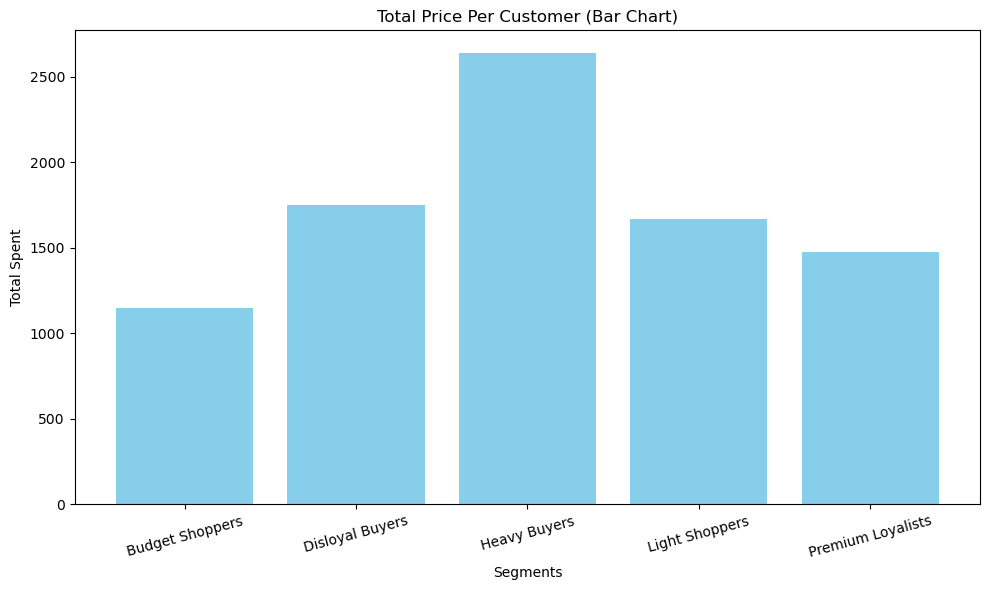

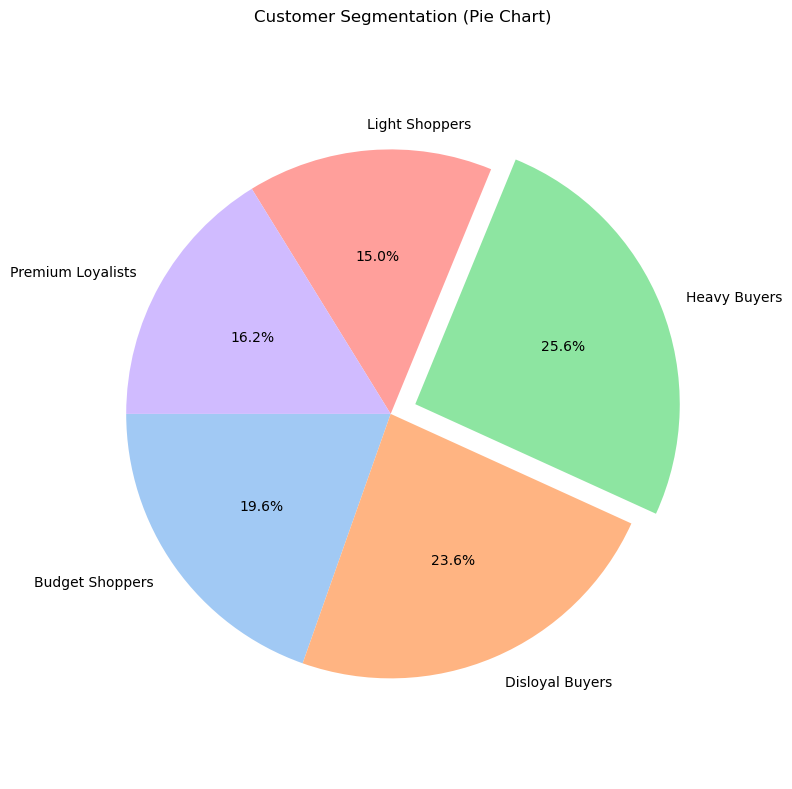

In [8]:
analyzer.customer_segmentation_analysis()

The function below helps analyze our different products according to the quantity sold, amount of revenue brought in and level of satisfaction they provide buyers. It also visualizes the analysis using a stacked bar chart with amount of revenue stacked on quantity sold for each product and each box annotated with their level of satisfaction.



 ======================================== PRODUCT ANALYSIS ========================================
['date', 'time', 'customer', 'age', 'gender', 'location', 'online', 'productid', 'productname', 'category', 'quantity', 'unitprice', 'totalprice', 'paymentmode', 'promotion', 'discount', 'shippingmethod', 'deliverytime', 'satisfaction', 'year', 'month', 'day', 'weekday', 'weekend', 'agerange', 'daytime']
      category          productname  count    revenue  Average Satisfaction  \
0         Toys         Toys_Product   1097  183594.22                  2.98   
1  Electronics  Electronics_Product   1105  181077.53                  3.00   
2         Food         Food_Product   1077  179952.23                  2.96   
3     Clothing     Clothing_Product   1077  178172.64                  2.97   
4  Decorations  Decorations_Product   1062  178059.98                  3.04   

   percentofrevenue  count(scaled)  revenue(scaled)  
0             20.38       0.813953         1.000000  
1        

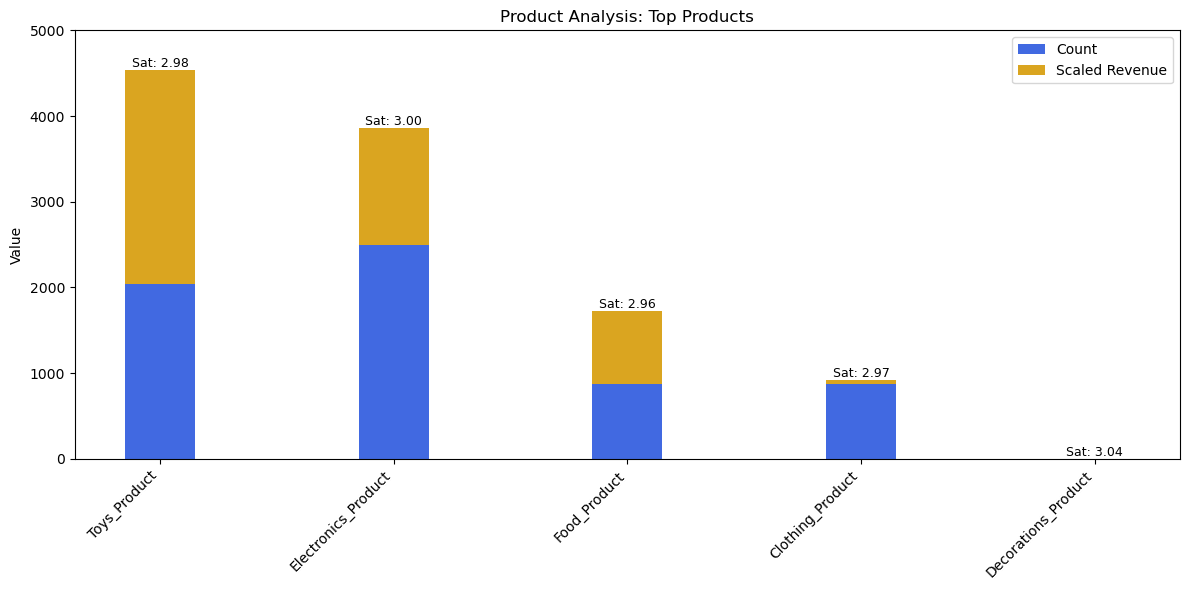

In [9]:
df_scaled, productsummary = analyzer.product_analysis()

The function below assists with encoding our non-numerical columns so that numerical operations can be carried out on them and they can be used to train our machine for prediction.

In [10]:
analyzer.ColumnEncoder()



 ======================================== ENCODER PREVIEW ========================================
         date                time  customer  age location  online  productid  \
0  2020-12-24 1900-01-01 07:27:59       441   27  City_15    True        106   
1  2022-11-18 1900-01-01 14:36:39       340   43  City_13    True        816   
6  2020-12-08 1900-01-01 08:26:56       368   63   City_3    True        158   
7  2020-12-03 1900-01-01 16:02:24       121   48   City_1    True        829   
11 2021-11-11 1900-01-01 07:42:19       300   51  City_13    True        755   

    quantity  unitprice  totalprice     paymentmode  promotion  discount  \
0        1.0   0.964327    0.967239     Credit Card      False  0.000000   
1        0.0   0.947585    0.174017     Credit Card       True  0.000000   
6        0.5   0.423968    0.274418  Online Payment      False  0.000000   
7        0.5   0.967472    0.573899            Cash       True  0.584188   
11       0.0   0.187746    0.034455  O

The function below is used to calculate our R2 score and predict the impact on revenue over different discount percentages. It also includes a line graph for visualization.



 ======================================== SALES & REVENUE PREDICTION ========================================

R2 Score: 0.4776634446105893

RMSE: 0.028293462367707464
        Feature  Coefficient
0      discount         0.29
1      quantity         0.40
2  satisfaction         0.00
3       weekday         0.00
4       weekend        -0.00


Predicted Revenue Change: 0.03 units
Revenue Percentage Change: 9.11%


 ======================================== DISCOUNT ANALYSIS SUMMARY ========================================
Discount  Avg Predicted Revenue  Avg Satisfaction  Weekend Sales Count  Weekend Revenue  Weekend Percentage  Weekday Sales Count  Weekday Revenue  Weekday Percentage
      0%               0.454772          0.517635                   75        36.284983              -64.75                   27        12.809830              -71.59
     10%               0.395513          0.494565                  139        57.101201              -44.52                   62        24.13

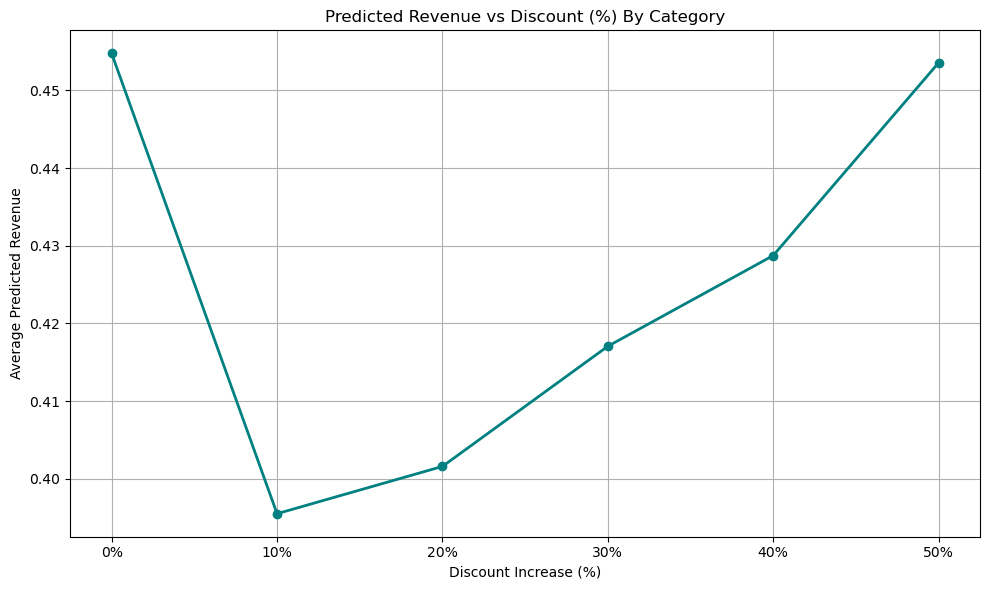

In [11]:
analyzer.SalesPredictionModel()

Tried using the lines of code below to predict how increase in discount impacts the quantity sold and revenue income for each product and plot it in a line graph but couldn't. The lines of code are expected to be in the function SalesPredictionModel() 

In [12]:
 # discountsteps = np.linspace (0, 0.5, 6)
        # results = []
        # products = x_test["productname"].unique()
        # for product in products:
        #     product_mask = x_test["productname"] == product

        #     baseline = x_test.copy()
        #     y_predbaseline = model.predict(baseline)
        #     baselineweekend = y_predbaseline[(baseline["weekend"] == 1) & product_mask].sum()
        #     baselineweekday = y_predbaseline[(baseline["weekday"] == 1) & product_mask].sum()
        #     baselineavg = np.mean(y_predbaseline[product_mask])

        # for step in discountsteps:
        #     scenario = x_test.copy()
        #     scenario["discount"] = np.where(scenario["productname"] == product, (scenario["discount"] + step).clip(upper = 1.0), scenario["discount"])
        #     y_pred  = model.predict(scenario)

        #     avgrevenue = np.mean(y_pred)
        #     avgsatisfaction = np.mean(scenario["satisfaction"]) if "satisfaction" in scenario else None
           
            # if "weekend" in scenario.columns:
            #     weekendsales = scenario[scenario["weekend"] == 1]
            #     weekendsalescount = len(weekendsales)
            #     weekendrevenue = y_pred[scenario["weekend"] == 1].sum()
            #     weekendpercentage = ((weekendrevenue - baselineweekend) / baselineweekend) * 100 
            #     weekdaysales = scenario[scenario["weekday"] == 1]
            #     weekdaysalescount = len(weekdaysales)
            #     weekdayrevenue = y_pred[scenario["weekday"] == 1].sum()
            #     weekdaypercentage = ((weekdayrevenue - baselineweekday) / baselineweekday) * 100 
            # else:
            #     weekendsalescount = 0
            #     weekendrevenue = 0
            #     weekdaysalescount = 0
            #     weekdayrevenue = 0
            #     weekendpercentage = 0
            #     weekdaypercentage = 0
            

            # results.append({
            #     "Product": product,
            #     "Discount": f"+ {int(step * 100)}%",
            #     "Avg Predicted Revenue": avgrevenue,
            #     "Avg Satisfaction": avgsatisfaction,
            #     "Weekend Sales Count": weekendsalescount,
            #     "Weekend Revenue": weekendrevenue,
            #     "Weekend Percentage": weekendpercentage,
            #     "Weekday Sales Count": weekdaysalescount,
            #     "Weekday Revenue": weekdayrevenue,
            #     "Weekday Percentage": weekdaypercentage,
            # })
            
        # df_discountanalysis = pd.DataFrame(results)
        # print(df_discountanalysis)

        # discounts = discountsteps * 100
        # for category, metrics in results.items():
        #     plt.figure(figsize = (10,6))
        #     for i, (metricname, values) in enumerate(metrics.items()):
        #         plt.plot(discounts, values, label = metricname. title(), marker = 'o', color = sns.colorpalette("husl", 5)[i], linewidth = 2)
        #         revenuevalues = metrics["revenue"]
        #         peakindex = np.argmax(revenuevalues)
        #         elbowindex = next((i for i in range(1, len(revenuevalues) - 1) if revenuevalues[i] - revenuevalues[i-1] < 0.01), peakindex)
        #         peakdiscount = discounts[peakindex]
        #         elbowdiscount = discounts[elbowindex]
        # plt.axvline(x = peakdiscount, linestyle = "--", color = "gold", label = f"Peak Revenue: {peakdiscount}%")
        # plt.axvline(x = elbowdiscount, linestyle = "--", color = "red", label = f"Elbow Point: {elbowdiscount}%")
        # plt.title("Predicted Revenue vs Discount (%) By Category")
        # plt.xlabel("Discount Increase (%)")
        # plt.ylabel("Average Value /  Revenue")
        # plt.legend()
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()
